# **Data Science Assessment for Andani**

In [483]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
import glob
import os


In [484]:
csv_files = glob.glob('oulad_data/*.csv')
dataframes = {os.path.basename(file): pd.read_csv(file) for file in csv_files}

### **Data Pre-Processing and Exploration**

In [485]:
dataframes.keys()

dict_keys(['assessments.csv', 'courses.csv', 'studentAssessment.csv', 'studentInfo.csv', 'studentRegistration.csv', 'studentVle.csv', 'vle.csv'])

In [486]:
for name in list(dataframes.keys()):
    old_name = name
    new_name = name.removesuffix(".csv")
    dataframes.update( {new_name: dataframes.pop(old_name)})

In [487]:
dataframes.keys()

dict_keys(['assessments', 'courses', 'studentAssessment', 'studentInfo', 'studentRegistration', 'studentVle', 'vle'])

In [488]:
dataframes['assessments'].head(10)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1,TMA,30,20
1,AAA,2013J,2,TMA,75,20
2,AAA,2013J,3,TMA,120,20
3,AAA,2013J,4,Exam,230,100
4,AAA,2014B,5,TMA,30,20
5,AAA,2014B,6,CMA,75,30
6,AAA,2014B,7,TMA,120,20
7,AAA,2014B,8,Exam,230,100
8,BBB,2013J,9,CMA,30,30
9,BBB,2013J,10,CMA,75,30


In [489]:
dataframes['courses'].head()

,code_module,code_presentation,length
0,AAA,2013J,240
1,AAA,2014B,240
2,BBB,2013J,240
3,BBB,2014B,240
4,CCC,2013J,240


In [490]:
dataframes['studentAssessment'].head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1,9,26,0,29
1,1,10,28,0,55
2,1,12,29,0,76
3,1,16,27,0,24
4,1,19,24,0,19


In [491]:
#def     total_weighted_score(score)

In [492]:
dataframes['studentInfo'].head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,BBB,2014B,1,M,Wales,A Level or Equivalent,20-30%,55<=,2,90,N,Fail
1,EEE,2014B,2,F,North Region,A Level or Equivalent,40-50%,0-35,1,150,N,Pass
2,DDD,2013J,2,M,South East Region,Post Graduate Qualification,20-30%,55<=,0,90,N,Fail
3,CCC,2014B,3,F,South East Region,HE Qualification,90-100%,0-35,1,120,N,Fail
4,BBB,2014B,4,M,South Region,A Level or Equivalent,70-80%,35-55,1,60,N,Distinction


In [493]:
dataframes['studentInfo'].id_student.nunique()

1000

In [494]:
dataframes['studentRegistration'].head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,BBB,2014B,1,-51,NaN
1,EEE,2014B,2,-40,NaN
2,DDD,2013J,2,-56,NaN
3,CCC,2014B,3,-50,NaN
4,BBB,2014B,4,-39,NaN


In [495]:
dataframes['studentVle'].head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,BBB,2014B,1,68,57,1
1,BBB,2014B,1,63,73,3
2,BBB,2014B,1,67,176,3
3,BBB,2014B,1,76,53,9
4,BBB,2014B,1,79,193,4


In [496]:
dataframes['studentVle'].id_student.nunique()

1000

In [497]:
dataframes['vle'].head(10)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,1,AAA,2013J,quiz,4,12
1,2,AAA,2013J,subpage,25,32
2,3,AAA,2013J,page,4,7
3,4,AAA,2013J,glossary,7,11
4,5,AAA,2013J,oucontent,20,21
5,6,AAA,2013J,glossary,27,34
6,7,AAA,2013J,resource,26,30
7,8,AAA,2013J,forum,3,6
8,9,AAA,2013J,quiz,1,5
9,10,AAA,2013J,subpage,1,9


In [498]:
dataframes['vle']['number_of_weeks_on_vle'] = dataframes['vle'].week_to - dataframes['vle'].week_from
dataframes['vle']['activity_count'] = 1
dataframes['vle'].head(10)

,id_site,code_module,code_presentation,activity_type,week_from,week_to,number_of_weeks_on_vle,activity_count
0,1,AAA,2013J,quiz,4,12,8,1
1,2,AAA,2013J,subpage,25,32,7,1
2,3,AAA,2013J,page,4,7,3,1
3,4,AAA,2013J,glossary,7,11,4,1
4,5,AAA,2013J,oucontent,20,21,1,1
5,6,AAA,2013J,glossary,27,34,7,1
6,7,AAA,2013J,resource,26,30,4,1
7,8,AAA,2013J,forum,3,6,3,1
8,9,AAA,2013J,quiz,1,5,4,1
9,10,AAA,2013J,subpage,1,9,8,1


In [499]:
df_studentVle = dataframes['studentVle'].groupby(['id_site','code_module','code_presentation','id_student'],sort=False)['sum_click'].sum().reset_index()

In [500]:
df_studentVle

,id_site,code_module,code_presentation,id_student,sum_click
0,68,BBB,2014B,1,13
1,63,BBB,2014B,1,17
2,67,BBB,2014B,1,36
3,76,BBB,2014B,1,34
4,79,BBB,2014B,1,11
...,...,...,...,...,...
27092,26,AAA,2014B,1000,21
27093,38,AAA,2014B,1000,19
27094,28,AAA,2014B,1000,32
27095,24,AAA,2014B,1000,16


In [501]:
print(df_studentVle.id_student.nunique())
dataframes['studentVle'].id_site.nunique()

1000


200

In [502]:
df_studentVle[df_studentVle.id_student==100]

,id_site,code_module,code_presentation,id_student,sum_click
2557,79,BBB,2014B,100,36
2558,61,BBB,2014B,100,60
2559,71,BBB,2014B,100,28
2560,62,BBB,2014B,100,40
2561,76,BBB,2014B,100,42
2562,70,BBB,2014B,100,34
2563,72,BBB,2014B,100,38
2564,65,BBB,2014B,100,22
2565,77,BBB,2014B,100,45
2566,63,BBB,2014B,100,19


In [503]:
vle_df = df_studentVle.merge(dataframes['vle'], on = ['id_site','code_module','code_presentation'],how = 'left')

In [504]:
vle_df

,id_site,code_module,code_presentation,id_student,sum_click,activity_type,week_from,week_to,number_of_weeks_on_vle,activity_count
0,68,BBB,2014B,1,13,url,23,24,1,1
1,63,BBB,2014B,1,17,url,26,31,5,1
2,67,BBB,2014B,1,36,forum,8,14,6,1
3,76,BBB,2014B,1,34,oucontent,4,11,7,1
4,79,BBB,2014B,1,11,page,26,28,2,1
...,...,...,...,...,...,...,...,...,...,...
27092,26,AAA,2014B,1000,21,glossary,27,32,5,1
27093,38,AAA,2014B,1000,19,page,26,35,9,1
27094,28,AAA,2014B,1000,32,url,22,31,9,1
27095,24,AAA,2014B,1000,16,url,26,27,1,1


In [505]:
vle_df = vle_df.groupby(['code_module','code_presentation','id_student'],sort=False)[['sum_click','number_of_weeks_on_vle','activity_count']].sum().reset_index()
vle_df

,code_module,code_presentation,id_student,sum_click,number_of_weeks_on_vle,activity_count
0,BBB,2014B,1,375,96,20
1,EEE,2014B,2,201,74,15
2,DDD,2013J,2,52,59,9
3,CCC,2014B,3,245,91,19
4,BBB,2014B,4,780,94,19
...,...,...,...,...,...,...
1502,EEE,2013J,998,446,102,20
1503,BBB,2014B,998,461,96,20
1504,AAA,2014B,999,155,83,15
1505,EEE,2014B,999,244,80,17


In [506]:
for name in list(dataframes.keys()):
    print(f'number of rows in {name}: {len(dataframes[name])}')

number of rows in assessments: 40
number of rows in courses: 10
number of rows in studentAssessment: 5392
number of rows in studentInfo: 1507
number of rows in studentRegistration: 1507
number of rows in studentVle: 114130
number of rows in vle: 200


In [507]:
df_1 = dataframes['assessments'].merge(dataframes['courses'],on = ['code_module','code_presentation'] ,how = 'left')
df_1.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,length
0,AAA,2013J,1,TMA,30,20,240
1,AAA,2013J,2,TMA,75,20,240
2,AAA,2013J,3,TMA,120,20,240
3,AAA,2013J,4,Exam,230,100,240
4,AAA,2014B,5,TMA,30,20,240


In [508]:
df_1.shape

(40, 7)

In [509]:
df_1 = df_1.merge(dataframes['studentAssessment'],on = ['id_assessment'] ,how = 'left')
df_1.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,length,id_student,date_submitted,is_banked,score
0,AAA,2013J,1,TMA,30,20,240,9,26,0,29
1,AAA,2013J,1,TMA,30,20,240,10,28,0,55
2,AAA,2013J,1,TMA,30,20,240,12,29,0,76
3,AAA,2013J,1,TMA,30,20,240,16,27,0,24
4,AAA,2013J,1,TMA,30,20,240,19,24,0,19


In [510]:
#df_1[df_1.id_student == 1]
np.max(df_1[df_1.assessment_type == 'Exam']['score'])
df_1['weighted_score'] = (df_1['score']/100) * df_1['weight']
df_1.head(10)

,code_module,code_presentation,id_assessment,assessment_type,date,weight,length,id_student,date_submitted,is_banked,score,weighted_score
0,AAA,2013J,1,TMA,30,20,240,9,26,0,29,5.8
1,AAA,2013J,1,TMA,30,20,240,10,28,0,55,11.0
2,AAA,2013J,1,TMA,30,20,240,12,29,0,76,15.2
3,AAA,2013J,1,TMA,30,20,240,16,27,0,24,4.8
4,AAA,2013J,1,TMA,30,20,240,19,24,0,19,3.8
5,AAA,2013J,1,TMA,30,20,240,24,29,0,29,5.8
6,AAA,2013J,1,TMA,30,20,240,29,29,0,58,11.6
7,AAA,2013J,1,TMA,30,20,240,30,27,0,73,14.6
8,AAA,2013J,1,TMA,30,20,240,43,25,0,83,16.6
9,AAA,2013J,1,TMA,30,20,240,49,30,0,84,16.8


In [511]:
cols = ['code_module', 'code_presentation', 'assessment_type','length','id_student','is_banked']

df = df_1.groupby(cols,as_index=False)[['weighted_score','weight']].sum()

In [512]:
df[df['id_student']==1]

,code_module,code_presentation,assessment_type,length,id_student,is_banked,weighted_score,weight
1045,BBB,2014B,CMA,240,1,0,12.6,60
1208,BBB,2014B,Exam,240,1,0,18.0,100
1362,BBB,2014B,TMA,240,1,0,10.2,20


In [513]:
cols = ['code_module', 'code_presentation','length','id_student','is_banked']
df = df_1.groupby(cols,as_index=False)[['weighted_score','weight']].sum()

In [514]:
df

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight
0,AAA,2013J,240,9,0,63.4,160
1,AAA,2013J,240,10,0,92.8,160
2,AAA,2013J,240,12,0,121.2,160
3,AAA,2013J,240,16,0,77.6,160
4,AAA,2013J,240,19,0,33.4,160
...,...,...,...,...,...,...,...
1424,EEE,2014B,240,955,0,40.8,160
1425,EEE,2014B,240,980,0,145.4,160
1426,EEE,2014B,240,985,0,141.0,160
1427,EEE,2014B,240,986,0,24.8,160


In [515]:
df.shape

(1429, 7)

In [516]:
df_1 = df.merge(dataframes['studentInfo'],on = ['code_module','code_presentation','id_student'] ,how = 'left')
df_1.head()

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,240,9,0,63.4,160,F,South East Region,Post Graduate Qualification,80-90%,55<=,1,30,N,Fail
1,AAA,2013J,240,10,0,92.8,160,F,North Western Region,HE Qualification,40-50%,0-35,0,90,N,Pass
2,AAA,2013J,240,12,0,121.2,160,M,South Region,Post Graduate Qualification,30-40%,55<=,1,90,N,Pass
3,AAA,2013J,240,16,0,77.6,160,F,Wales,HE Qualification,0-10%,0-35,0,90,N,Fail
4,AAA,2013J,240,19,0,33.4,160,F,East Midlands Region,No Formal quals,90-100%,55<=,0,120,N,Fail


In [517]:
df_1[df_1['id_student']==980]

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
1425,EEE,2014B,240,980,0,145.4,160,M,East Anglian Region,Lower Than A Level,80-90%,35-55,0,90,N,Distinction


In [518]:
df_1.shape

(1429, 16)

In [519]:
df_1 = df_1.merge(dataframes['studentRegistration'],on = ['code_module','code_presentation','id_student'] ,how = 'left')
df_1.head()

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,240,9,0,63.4,160,F,South East Region,Post Graduate Qualification,80-90%,55<=,1,30,N,Fail,-15,NaN
1,AAA,2013J,240,10,0,92.8,160,F,North Western Region,HE Qualification,40-50%,0-35,0,90,N,Pass,-25,NaN
2,AAA,2013J,240,12,0,121.2,160,M,South Region,Post Graduate Qualification,30-40%,55<=,1,90,N,Pass,-38,NaN
3,AAA,2013J,240,16,0,77.6,160,F,Wales,HE Qualification,0-10%,0-35,0,90,N,Fail,-41,NaN
4,AAA,2013J,240,19,0,33.4,160,F,East Midlands Region,No Formal quals,90-100%,55<=,0,120,N,Fail,-27,NaN


In [520]:
df_1.shape

(1429, 18)

In [521]:
df_studentVle.head()

,id_site,code_module,code_presentation,id_student,sum_click
0,68,BBB,2014B,1,13
1,63,BBB,2014B,1,17
2,67,BBB,2014B,1,36
3,76,BBB,2014B,1,34
4,79,BBB,2014B,1,11


In [522]:
cols = ['code_module', 'code_presentation','length','id_student','is_banked']
df = df_1.groupby(cols,as_index=False)[['weighted_score','weight']].sum()

In [523]:
df_1 = df_1.merge(vle_df,on = ['code_module','code_presentation','id_student'] ,how = 'left')
df_1.head(15)

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,...,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,number_of_weeks_on_vle,activity_count
0,AAA,2013J,240,9,0,63.4,160,F,South East Region,Post Graduate Qualification,...,55<=,1,30,N,Fail,-15,NaN,148,72,14
1,AAA,2013J,240,10,0,92.8,160,F,North Western Region,HE Qualification,...,0-35,0,90,N,Pass,-25,NaN,448,97,20
2,AAA,2013J,240,12,0,121.2,160,M,South Region,Post Graduate Qualification,...,55<=,1,90,N,Pass,-38,NaN,335,97,20
3,AAA,2013J,240,16,0,77.6,160,F,Wales,HE Qualification,...,0-35,0,90,N,Fail,-41,NaN,108,84,18
4,AAA,2013J,240,19,0,33.4,160,F,East Midlands Region,No Formal quals,...,55<=,0,120,N,Fail,-27,NaN,417,97,20
5,AAA,2013J,240,24,0,62.4,160,F,London Region,Post Graduate Qualification,...,35-55,2,120,N,Fail,-45,NaN,191,79,17
6,AAA,2013J,240,29,0,21.6,40,M,Wales,A Level or Equivalent,...,55<=,1,60,N,Withdrawn,-13,148.0,149,66,14
7,AAA,2013J,240,30,0,126.2,160,F,South East Region,Post Graduate Qualification,...,0-35,1,150,N,Pass,-54,NaN,521,97,20
8,AAA,2013J,240,43,0,139.6,160,F,North Western Region,Lower Than A Level,...,0-35,1,120,N,Distinction,-40,NaN,368,97,20
9,AAA,2013J,240,49,0,107.6,160,F,North Region,HE Qualification,...,35-55,2,30,N,Pass,-43,NaN,585,97,20


In [524]:
df_1.shape

(1429, 21)

In [525]:
df_1.shape

(1429, 21)

In [526]:
df_1.columns

Index(['code_module', 'code_presentation', 'length', 'id_student', 'is_banked',
       'weighted_score', 'weight', 'gender', 'region', 'highest_education',
       'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits',
       'disability', 'final_result', 'date_registration',
       'date_unregistration', 'sum_click', 'number_of_weeks_on_vle',
       'activity_count'],
      dtype='object')

In [527]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   code_module             1429 non-null   object 
 1   code_presentation       1429 non-null   object 
 2   length                  1429 non-null   int64  
 3   id_student              1429 non-null   int64  
 4   is_banked               1429 non-null   int64  
 5   weighted_score          1429 non-null   float64
 6   weight                  1429 non-null   int64  
 7   gender                  1429 non-null   object 
 8   region                  1429 non-null   object 
 9   highest_education       1429 non-null   object 
 10  imd_band                1429 non-null   object 
 11  age_band                1429 non-null   object 
 12  num_of_prev_attempts    1429 non-null   int64  
 13  studied_credits         1429 non-null   int64  
 14  disability              1429 non-null   

In [528]:
df_1.drop(['length', 'id_student','weight','is_banked'],axis=1, inplace=True)

## **Exploratory Data Analysis**

### **Descriptive Statistics**

In [529]:
df_1.describe()

,weighted_score,num_of_prev_attempts,studied_credits,date_registration,date_unregistration,sum_click,number_of_weeks_on_vle,activity_count
count,1429.000000,1429.000000,1429.000000,1429.000000,128.000000,1429.000000,1429.000000,1429.000000
mean,94.559132,0.997901,89.937019,-34.178446,122.968750,392.447866,88.595521,18.189643
std,47.220268,0.805702,42.715054,14.600840,43.795865,221.784814,16.888542,2.994814
min,0.000000,0.000000,30.000000,-59.000000,31.000000,20.000000,12.000000,4.000000
25%,50.600000,0.000000,60.000000,-47.000000,88.750000,216.000000,79.000000,18.000000
50%,113.200000,1.000000,90.000000,-34.000000,126.500000,363.000000,94.000000,20.000000
75%,129.200000,2.000000,120.000000,-21.000000,157.000000,527.000000,98.000000,20.000000
max,178.300000,2.000000,150.000000,-10.000000,198.000000,1091.000000,115.000000,20.000000


In [530]:
#df_1.drop(['length', 'score'], axis=1, inplace=True)

In [531]:
# vle_df.describe()

In [532]:
df_1.dtypes

code_module                object
code_presentation          object
weighted_score            float64
gender                     object
region                     object
highest_education          object
imd_band                   object
age_band                   object
num_of_prev_attempts        int64
studied_credits             int64
disability                 object
final_result               object
date_registration           int64
date_unregistration       float64
sum_click                   int64
number_of_weeks_on_vle      int64
activity_count              int64
dtype: object

In [533]:
df_categorical = df_1.select_dtypes(include=object)
len(df_categorical.columns)

9

In [534]:
df_numerical = df_1.select_dtypes(exclude=object)
len(df_numerical.columns)

8

In [535]:
for col in df_categorical.columns:
    unique = df_categorical[col].unique()
    unique.sort()
    print(f'- {col}: has {len(unique)} unique values \n  {unique}')

- code_module: has 5 unique values 
  ['AAA' 'BBB' 'CCC' 'DDD' 'EEE']
- code_presentation: has 2 unique values 
  ['2013J' '2014B']
- gender: has 2 unique values 
  ['F' 'M']
- region: has 11 unique values 
  ['East Anglian Region' 'East Midlands Region' 'London Region'
 'North Region' 'North Western Region' 'Scotland' 'South East Region'
 'South Region' 'South West Region' 'Wales' 'West Midlands Region']
- highest_education: has 5 unique values 
  ['A Level or Equivalent' 'HE Qualification' 'Lower Than A Level'
 'No Formal quals' 'Post Graduate Qualification']
- imd_band: has 10 unique values 
  ['0-10%' '10-20%' '20-30%' '30-40%' '40-50%' '50-60%' '60-70%' '70-80%'
 '80-90%' '90-100%']
- age_band: has 3 unique values 
  ['0-35' '35-55' '55<=']
- disability: has 2 unique values 
  ['N' 'Y']
- final_result: has 4 unique values 
  ['Distinction' 'Fail' 'Pass' 'Withdrawn']


In [536]:
def categorize_region(region):
    if region in ['North Region', 'North Western Region', 'Scotland']:
        return 'North'
    elif region in ['East Midlands Region', 'West Midlands Region']:
        return 'Midlands'
    elif region in ['South Region', 'South West Region']:
        return 'South'
    elif region in ['South East Region', 'London Region']:
        return 'South East & London'
    elif region in ['East Anglian Region', 'Wales']:
        return 'East & Wales'
    else:
        return 'Unknown'

df_1['Area'] = df_1['region'].apply(categorize_region)
df_1[['Area','region']]

,Area,region
0,South East & London,South East Region
1,North,North Western Region
2,South,South Region
3,East & Wales,Wales
4,Midlands,East Midlands Region
...,...,...
1424,South East & London,South East Region
1425,East & Wales,East Anglian Region
1426,East & Wales,East Anglian Region
1427,Midlands,East Midlands Region


In [537]:
def categorize_band(percentage):
    if percentage in ['0-10%', '10-20%']:
        return 'Very Low'
    elif percentage in ['20-30%', '30-40%']:
        return 'Low'
    elif percentage in ['40-50%', '50-60%']:
        return 'Medium'
    elif percentage in ['60-70%', '70-80%']:
        return 'High'
    elif percentage in ['80-90%', '90-100%']:
        return 'Very High'
    else:
        return 'Unknown'

# Apply the function
df_1['percent range'] = df_1['imd_band'].apply(categorize_band)
df_1[['imd_band','percent range']]

,imd_band,percent range
0,80-90%,Very High
1,40-50%,Medium
2,30-40%,Low
3,0-10%,Very Low
4,90-100%,Very High
...,...,...
1424,60-70%,High
1425,80-90%,Very High
1426,30-40%,Low
1427,90-100%,Very High


In [538]:
def categorize_qualification(qual):
    if qual == 'No Formal quals':
        return 'None'
    elif qual == 'Lower Than A Level':
        return 'Lower Than A'
    elif qual == 'A Level or Equivalent':
        return 'Mid or A-level'
    elif qual == 'HE Qualification':
        return 'Higher'
    elif qual == 'Post Graduate Qualification':
        return 'Postgrad'
    else:
        return 'Unknown'

# Apply the function
df_1['Qualification'] = df_1['highest_education'].apply(categorize_qualification)

In [539]:
df_1.drop(['region','imd_band','highest_education'], axis=1, inplace=True)

### **Data Visualisation**

In [540]:
df_categorical = df_1.select_dtypes(include=object)
df_numerical = df_1.select_dtypes(exclude=object)

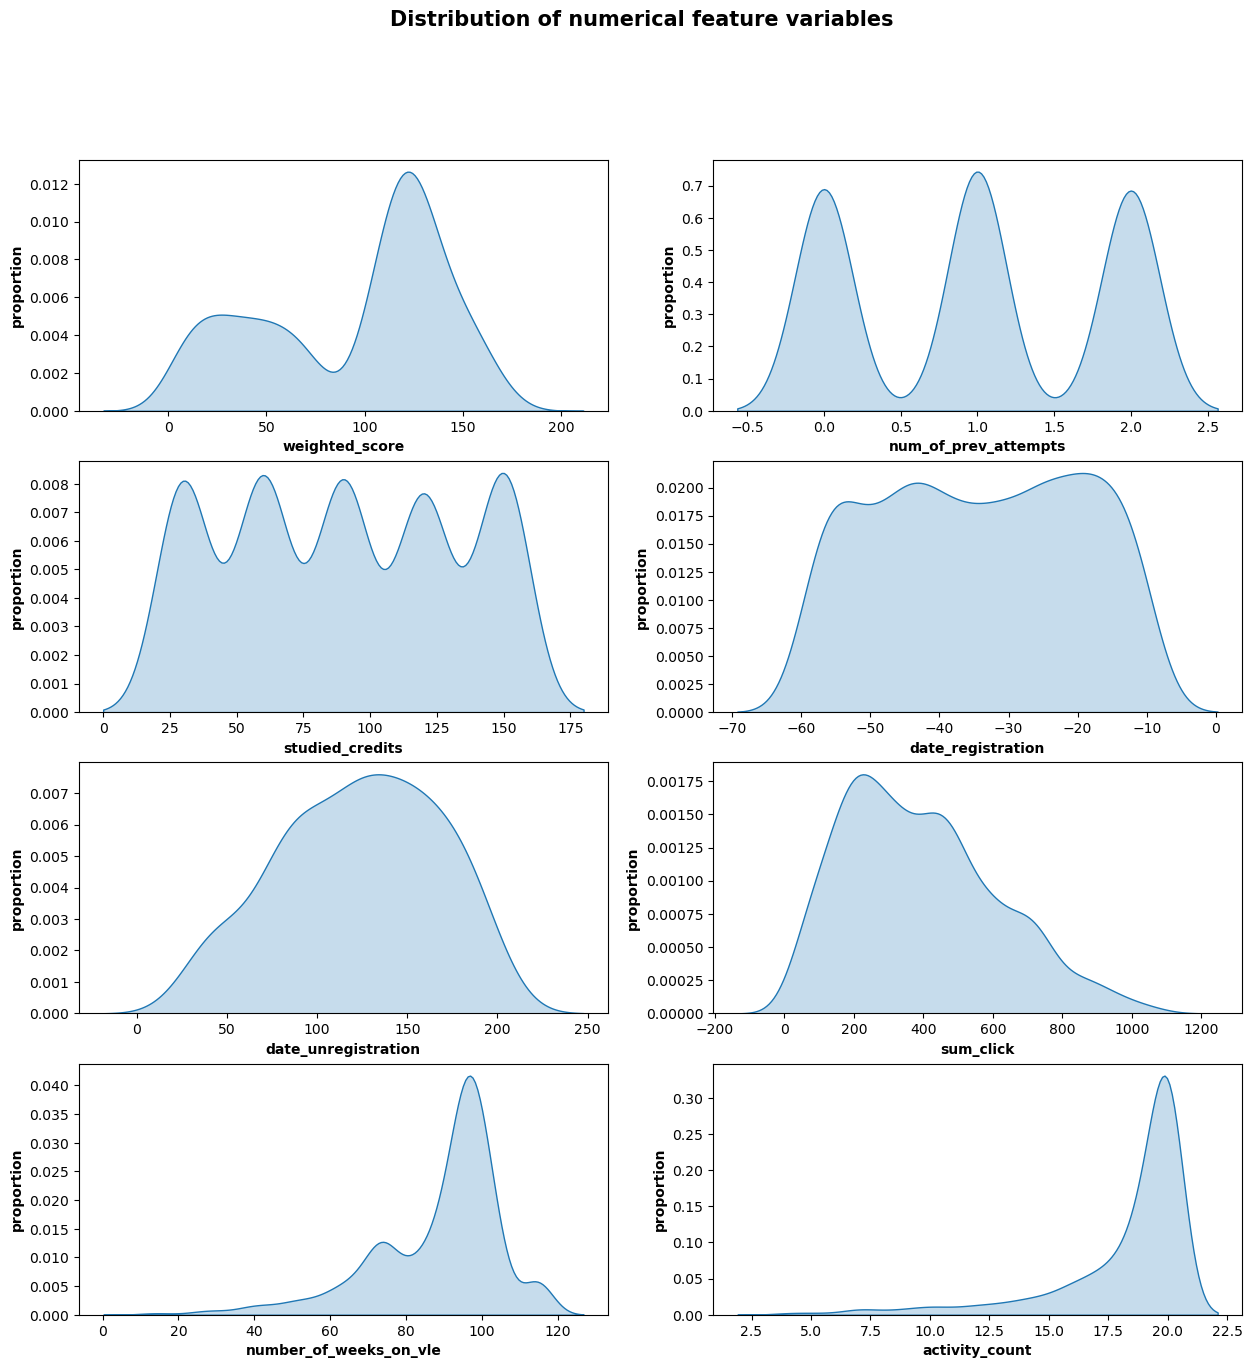

In [541]:
features_array = np.array(df_numerical.columns, dtype='object').reshape(4,2)
fig, ax  =  plt.subplots(4,2,sharey=False,figsize=(15,15))
for i, col in np.ndenumerate(features_array):
    sns.kdeplot(x =col, data = df_numerical, fill=True, ax = ax[i[0],i[1]])
    ax[i[0],i[1]].set_xlabel(col, fontweight="bold")
    ax[i[0],i[1]].set_ylabel("proportion", fontweight="bold")
plt.suptitle("Distribution of numerical feature variables", fontweight="bold", size=(15))
plt.show()

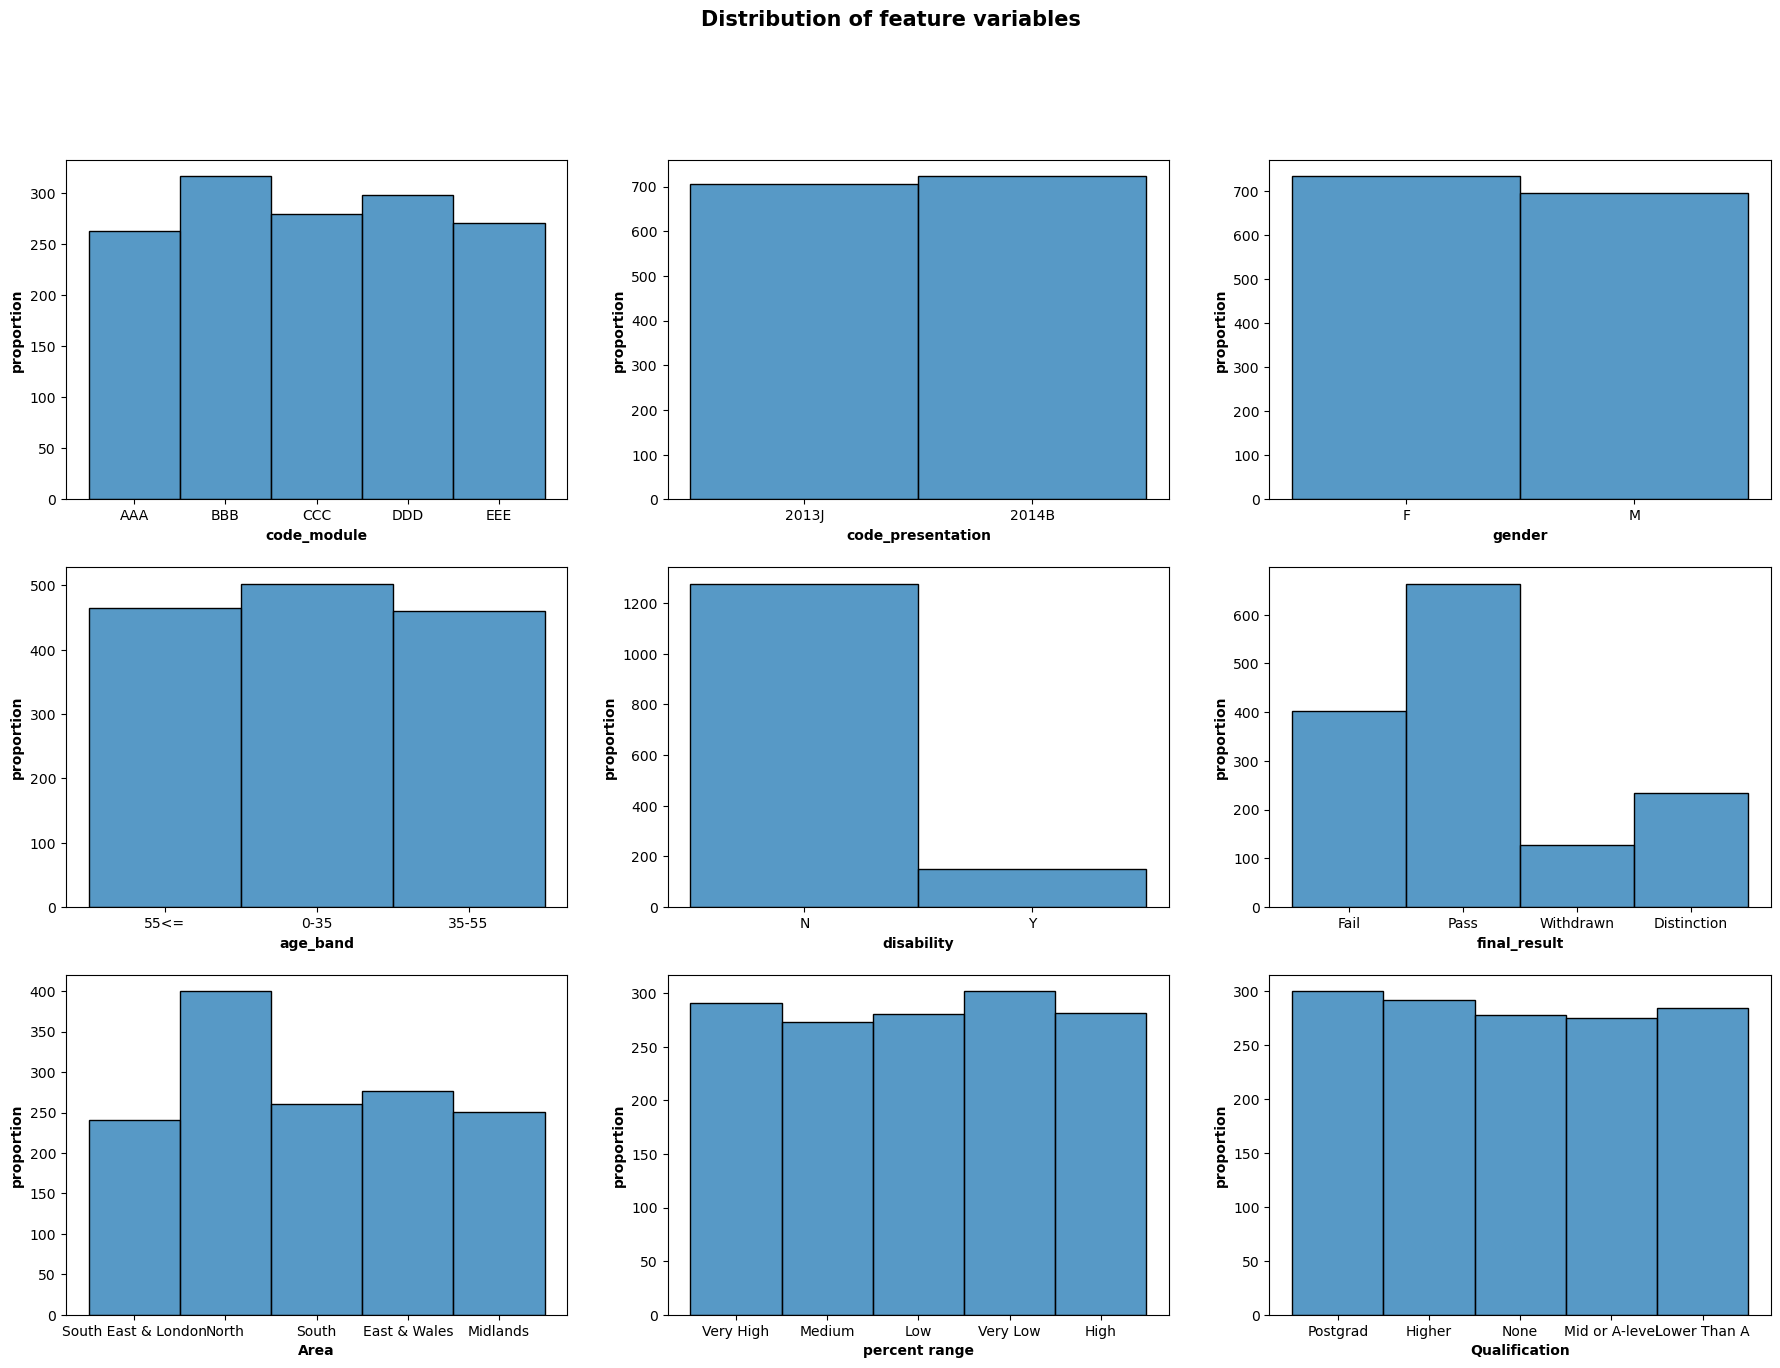

In [542]:
features_array_cat = np.array(df_categorical.columns, dtype='object').reshape(3,3)
fig, ax  =  plt.subplots(3,3,sharey=False,figsize=(22,15))
for i, col in np.ndenumerate(features_array_cat):
    sns.histplot(x =col, data = df_categorical, fill=True, ax = ax[i[0],i[1]])
    ax[i[0],i[1]].set_xlabel(col, fontweight="bold")
    ax[i[0],i[1]].set_ylabel("proportion", fontweight="bold")
plt.suptitle("Distribution of feature variables", fontweight="bold", size=(15))
plt.show()
#v

Text(0.5, 0.98, 'Relationship of feature variables and target Class')

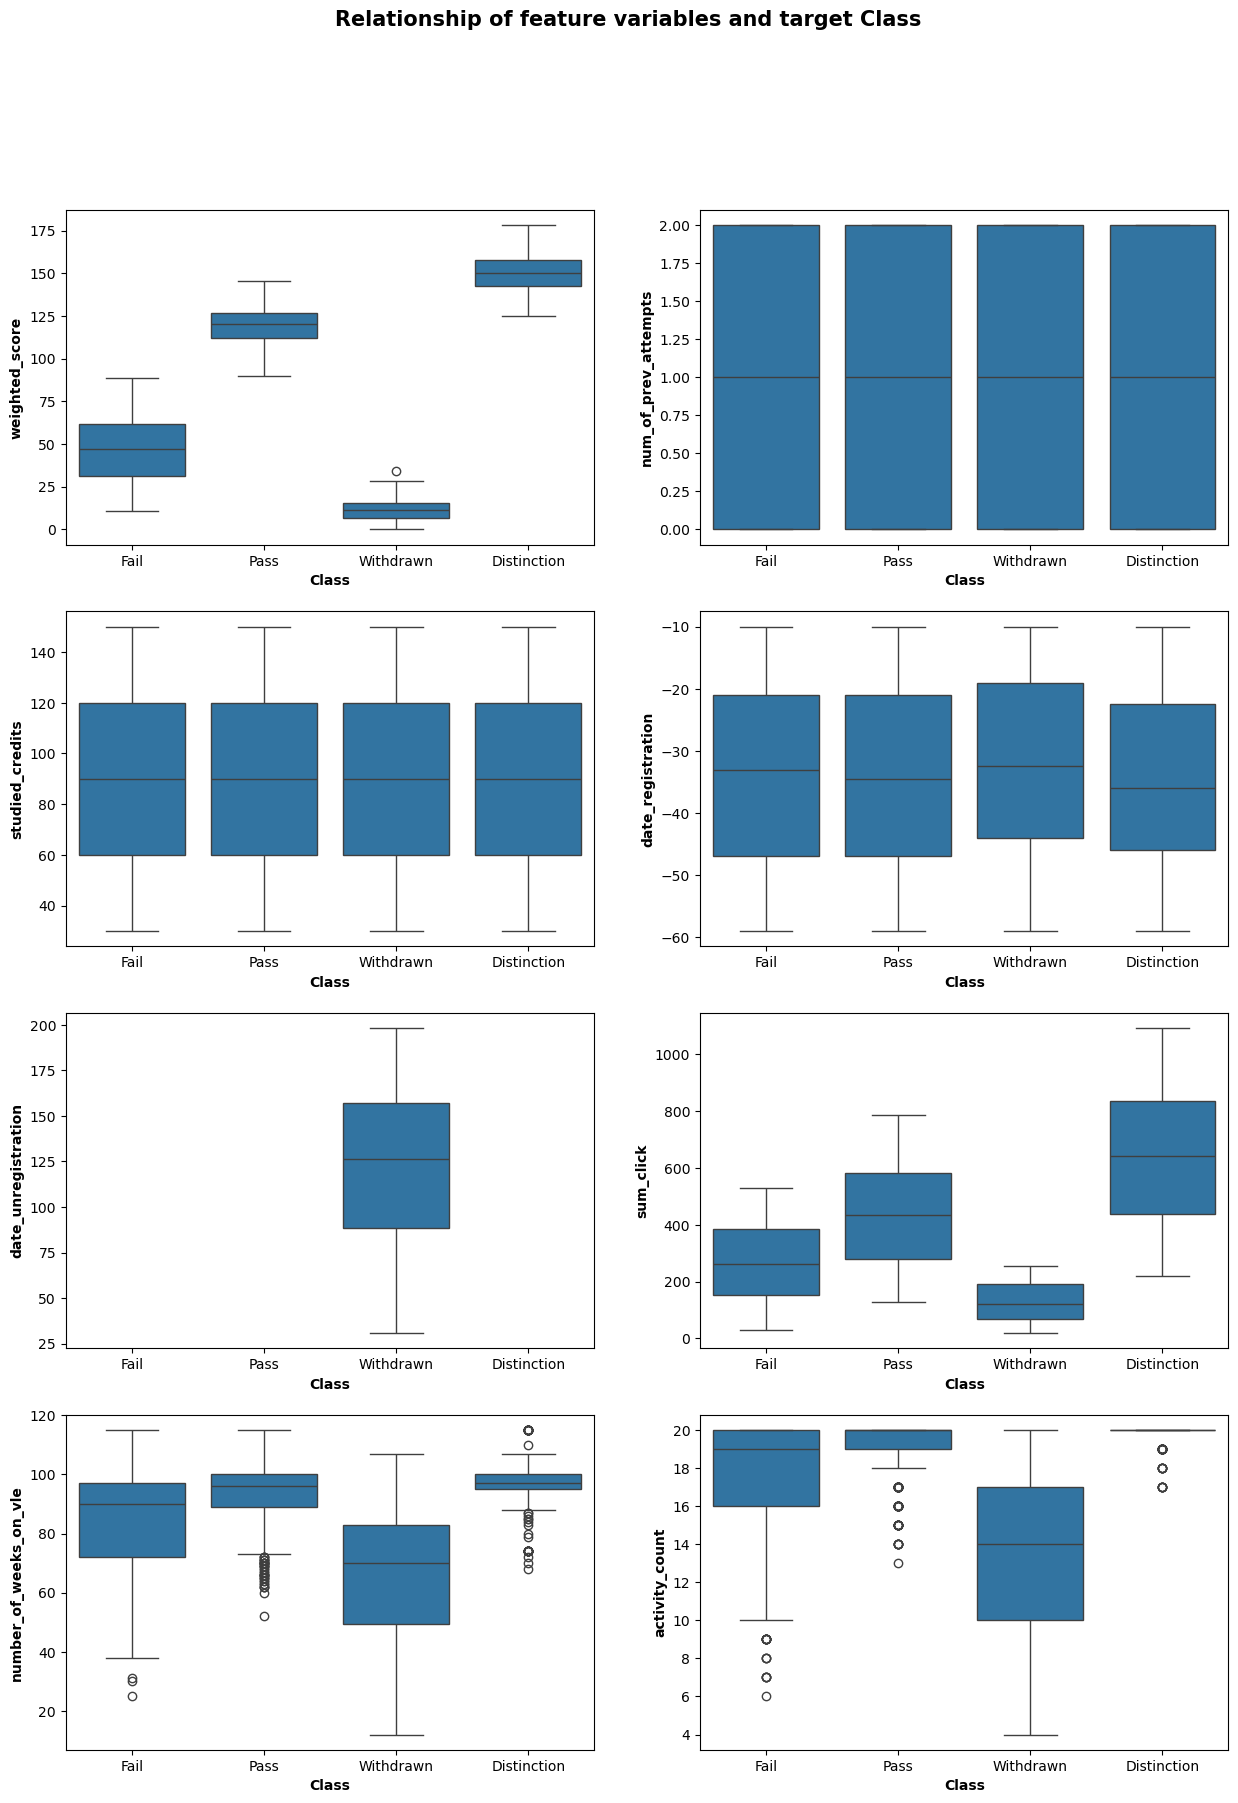

In [543]:
fig, ax  =  plt.subplots(4,2,sharey=False,figsize=(15,20 ))
for i, col in np.ndenumerate(features_array):
    sns.boxplot(ax = ax[i[0],i[1]], x = 'final_result', y = col , data = df_1)
    ax[i[0],i[1]].set_xlabel('Class', fontweight="bold")
    #ax[i[0],i[1]].set_xticklabels(['benign','malignant'],fontweight="bold")
    ax[i[0],i[1]].set_ylabel(col, fontweight="bold")
    
plt.suptitle("Relationship of feature variables and target Class", fontweight="bold", size=(15))